# Chapter 12: Generative UI

Generative UI represents an approach to rendering dynamic and interactive elements within chat windows or applications. This technique leverages the capabilities of LLMs to generate and manage various user interface components - such as images, tables, maps, and cards-on-the-fly. Generative UI offers several methods for achieving dynamic content generation:
- **Code generation and rendering:** In this approach, the LLM writes code to create visual elements. For instance, it could generate code to create a chart or image based on data analysis. The resulting code is executed to render the content, and the generated visual may be sent as binary data to the UI for display.
- **Tool-based rendering:** Here, rendering is driven by the tools invoked by the LLM. After a specific tool generates the desired output, the resulting data is sent to the UI for rendering. Typically, you focus on rendering the output for the most recent tool called, rather than displaying multiple widgets. This approach ensures that the UI remains dynamic and responsive, showing only the most relevant and updated information, thus avoiding clutter and maintaining a clean and interactive user experience.
- **Dynamic UI updates:** This technique involves asking the LLM to produce an output object that defines how the UI should be updated. For example, the LLM could generate an object that specifies new filters for charts or other interactive elements. This output is sent back to the frontend to dynamically update the user interface based on the latest data or user inputs.

Generative UI enhances user experiences by using LLMs to manage dynamic content. In this discussion, we will focus on the second and third approaches: Tool-based rendering and Dynamic UI updates.

![generative-ui](./assets/images/generative-ui.gif)

In [1]:
import geodatasets
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from assets.tools.earthquake import count_earthquakes, query_earthquakes, USGeopoliticalSurveyEarthquakeAPI
from pydantic import BaseModel, Field
from language_models.agent import (
    Agent,
    OutputType,
    PromptingStrategy,
)
from language_models.tools import Tool, current_date
from language_models.models.llm import OpenAILanguageModel
from language_models.proxy_client import ProxyClient
from language_models.settings import settings

In [2]:
proxy_client = ProxyClient(
    client_id=settings.CLIENT_ID,
    client_secret=settings.CLIENT_SECRET,
    auth_url=settings.AUTH_URL,
    api_base=settings.API_BASE,
)

For our example, we will render a map displaying earthquake locations using data provided by the earthquake AI agent. This map will be dynamically updated to reflect the most recent earthquake information, leveraging the capabilities of the AI agent to provide accurate and timely location data.

In [3]:
def plot_map(df: pd.DataFrame) -> None:
    earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    earthquakes.crs = "EPSG:4326"

    path = geodatasets.get_path("naturalearth.land")
    world = gpd.read_file(path)

    ax = world.plot(figsize=(20, 20), color="whitesmoke", linestyle=":", edgecolor="black")
    earthquakes.to_crs(epsg=4326).plot(markersize=30, ax=ax)
    plt.show()

## Tool-based Rendering

In Tool-based rendering, you generally allow the model to stream the output of the final tool back to the UI for rendering. For simplicity in our case, we will instead extract this information directly from the Chain-of-Thought process.

In [4]:
query_earthquakes_tool = Tool(
    function=query_earthquakes,
    name="Query Earthquakes",
    description="Use this tool to search recent earthquakes",
    args_schema=USGeopoliticalSurveyEarthquakeAPI,
)

count_earthquakes_tool = Tool(
    function=count_earthquakes,
    name="Count Earthquakes",
    description="Use this tool to count and aggregate recent earthquakes",
    args_schema=USGeopoliticalSurveyEarthquakeAPI,
)

system_prompt = "You are an United States Geological Survey expert who can answer questions regarding earthquakes."

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model="gpt-4",
    max_tokens=500,
    temperature=0.2,
)

agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{question}",
    prompt_variables=["question"],
    output_type=OutputType.STRING,
    tools=[current_date, count_earthquakes_tool, query_earthquakes_tool],
    prompting_strategy=PromptingStrategy.CHAIN_OF_THOUGHT,
    verbose=True,
)

In [5]:
output = agent.invoke({"question": "How many earthquakes occurred today?"})

Thought: To answer this question, I need to use the "Count Earthquakes" tool. I will need to set the start time to the beginning of today and the end time to the current time.
Tool: Current Date
Tool Input: {}
Tool Output: 2024-08-21 11:19:09.688927
Thought: Now that I have the current date and time, I can use the "Count Earthquakes" tool to find out how many earthquakes occurred today. The start time will be the beginning of today (2024-08-21 00:00:00) and the end time will be the current time (2024-08-21 11:19:09).
Tool: Count Earthquakes
Tool Input: {'start_time': '2024-08-21T00:00:00', 'end_time': '2024-08-21T11:19:09'}
Tool Output: {'count': 119, 'maxAllowed': 20000}
Thought: The tool output shows that there were 119 earthquakes today.
Final Answer: There were 119 earthquakes today.


In [6]:
print(output.final_answer)

There were 119 earthquakes today.


In [7]:
output = agent.invoke({"question": "Show me 3."})

Thought: To show details of 3 earthquakes that occurred today, I need to use the "Query Earthquakes" tool. I will set the start time to the beginning of today, the end time to the current time, and limit the results to 3.
Tool: Query Earthquakes
Tool Input: {'start_time': '2024-08-21T00:00:00', 'end_time': '2024-08-21T11:19:09', 'limit': 3}
Tool Output: {'type': 'FeatureCollection', 'metadata': {'generated': 1724231960000, 'url': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2024-08-21T00%3A00%3A00&endtime=2024-08-21T11%3A19%3A09&limit=3&mindepth=-100&maxdepth=1000&eventtype=earthquake', 'title': 'USGS Earthquakes', 'status': 200, 'api': '1.14.1', 'limit': 3, 'offset': 1, 'count': 3}, 'features': [{'type': 'Feature', 'properties': {'mag': 1.78, 'place': '14 km SW of Searles Valley, CA', 'time': 1724231809640, 'updated': 1724231938014, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/ci40709783', 'detail': 'https://earthquake.usgs.gov/fd

In [8]:
print(output.final_answer)

Here are the details of 3 earthquakes that occurred today:

1. A magnitude 1.78 earthquake occurred 14 km SW of Searles Valley, CA. More details can be found [here](https://earthquake.usgs.gov/earthquakes/eventpage/ci40709783).

2. A magnitude 1.78 earthquake occurred 7 km S of Volcano, Hawaii. More details can be found [here](https://earthquake.usgs.gov/earthquakes/eventpage/hv74416456).

3. A magnitude 1.6 earthquake occurred 12 km NE of Susitna, Alaska. More details can be found [here](https://earthquake.usgs.gov/earthquakes/eventpage/ak024ar4ukjc).


We locate the output of the last tool, create a dataframe from this data, and then render the map accordingly. In the UI, alongside displaying the final answer from the LLM as a string, we will also render this map. This process will be similar to the gif shown at the beginning, providing a visual representation of the data to complement the textual information.

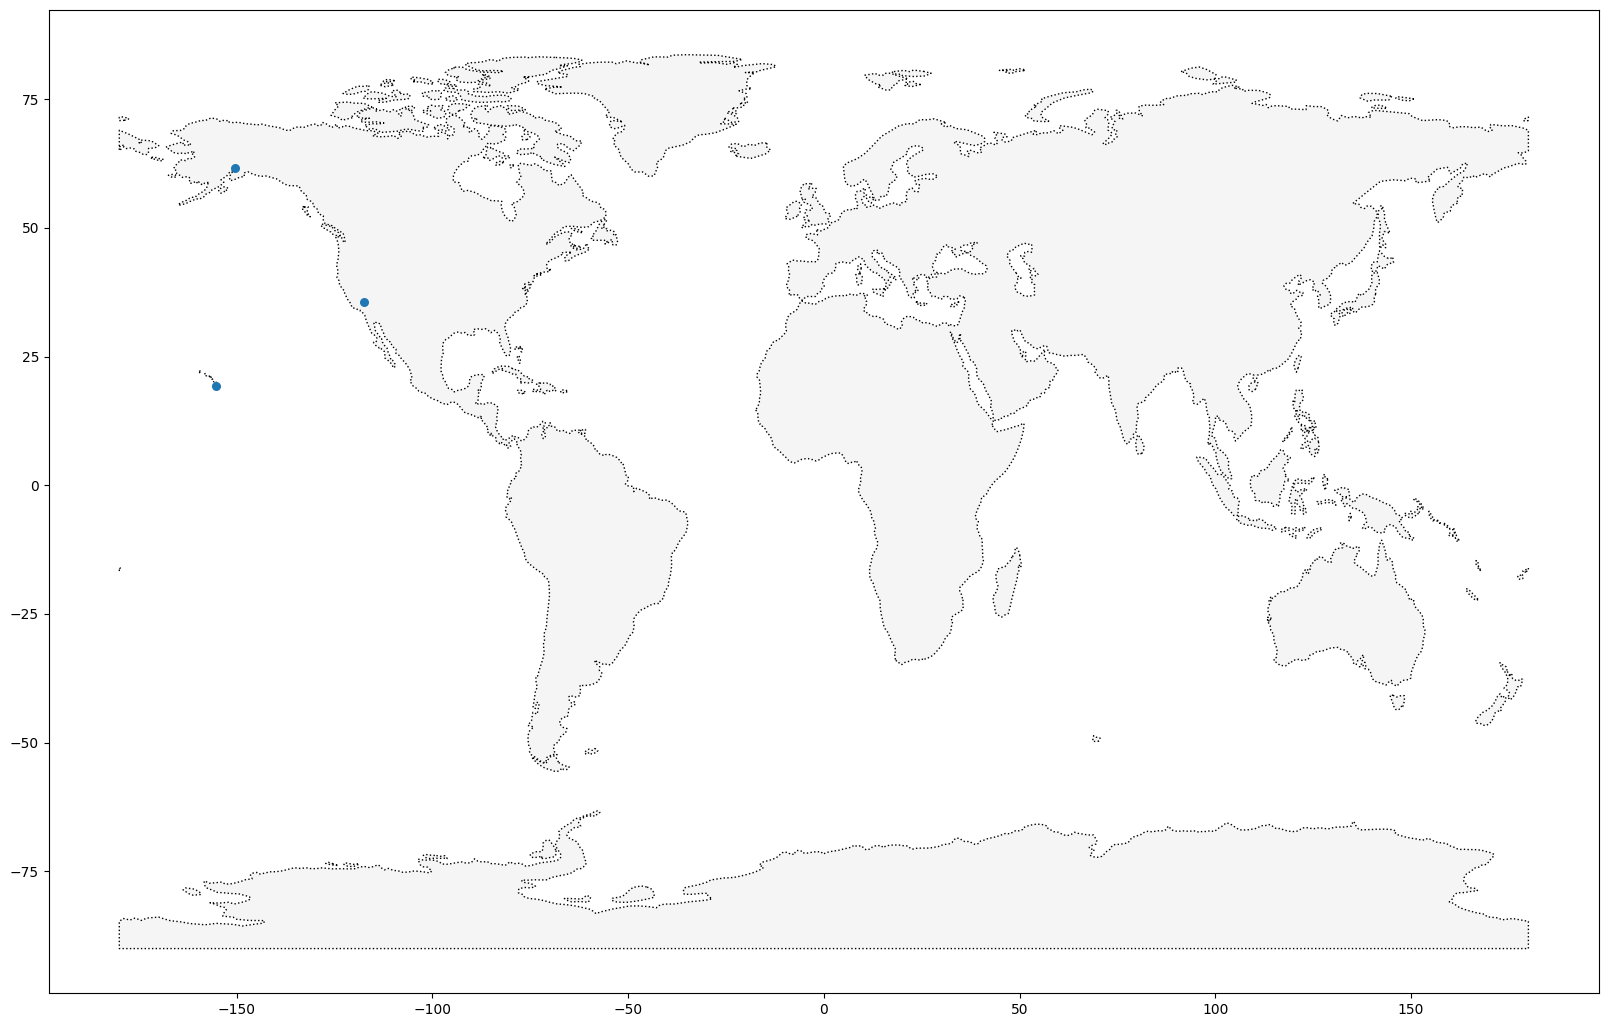

In [9]:
tool_output = None
for step in reversed(output.steps):
    if step.name == "tool_output":
        tool_output = step.content
        break

coordinates = []
for feature in tool_output["features"]:
    longitude, latitude, _ = feature["geometry"]["coordinates"]
    coordinates.append({'longitude': longitude, 'latitude': latitude})

df = pd.DataFrame(coordinates)
plot_map(df)

## Dynamic UI Updates

For dynamic UI updates, we instruct the LLM to generate an object that contains the location points, including latitude and longitude coordinates. This object is then used to render the map, ensuring that the UI dynamically reflects the latest location data provided by the LLM.

In [10]:
system_prompt = """You are an United States Geological Survey expert who can answer questions regarding earthquakes.

Within the JSON response you will find a point that holds the longitude and latitude:
geometry: {
    type: "Point",
    coordinates: [
        longitude,
        latitude,
        depth
    ]
}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model="gpt-4",
    max_tokens=500,
    temperature=0.2,
)

class Point(BaseModel):
    latitude: float = Field(description="Latitude of the earthquake")
    longitude: float = Field(description="Longitude of the earthquake")

class Location(BaseModel):
    points: list[Point] = Field(description="A list of points")

agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{question}",
    prompt_variables=["question"],
    output_type=OutputType.STRUCT,
    output_schema=Location,
    tools=[current_date, query_earthquakes_tool],
    prompting_strategy=PromptingStrategy.CHAIN_OF_THOUGHT,
    verbose=True,
)

In [11]:
output = agent.invoke({"question": "Show me 3 earthquakes that occurred today."})

Thought: To find the earthquakes that occurred today, I need to use the Current Date tool to get today's date. Then I will use the Query Earthquakes tool with the start_time and end_time set to today's date. I will also set the limit to 3 to get only 3 earthquakes.
Tool: Current Date
Tool Input: {}
Tool Output: 2024-08-21 11:19:35.727681
Thought: Now that I have the current date, I will use the Query Earthquakes tool to find the earthquakes that occurred today. I will set the start_time and end_time to today's date and limit the results to 3.
Tool: Query Earthquakes
Tool Input: {'start_time': '2024-08-21T00:00:00', 'end_time': '2024-08-21T23:59:59', 'limit': 3}
Tool Output: {'type': 'FeatureCollection', 'metadata': {'generated': 1724231980000, 'url': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2024-08-21T00%3A00%3A00&endtime=2024-08-21T23%3A59%3A59&limit=3&mindepth=-100&maxdepth=1000&eventtype=earthquake', 'title': 'USGS Earthquakes', 'status': 200, 'api'

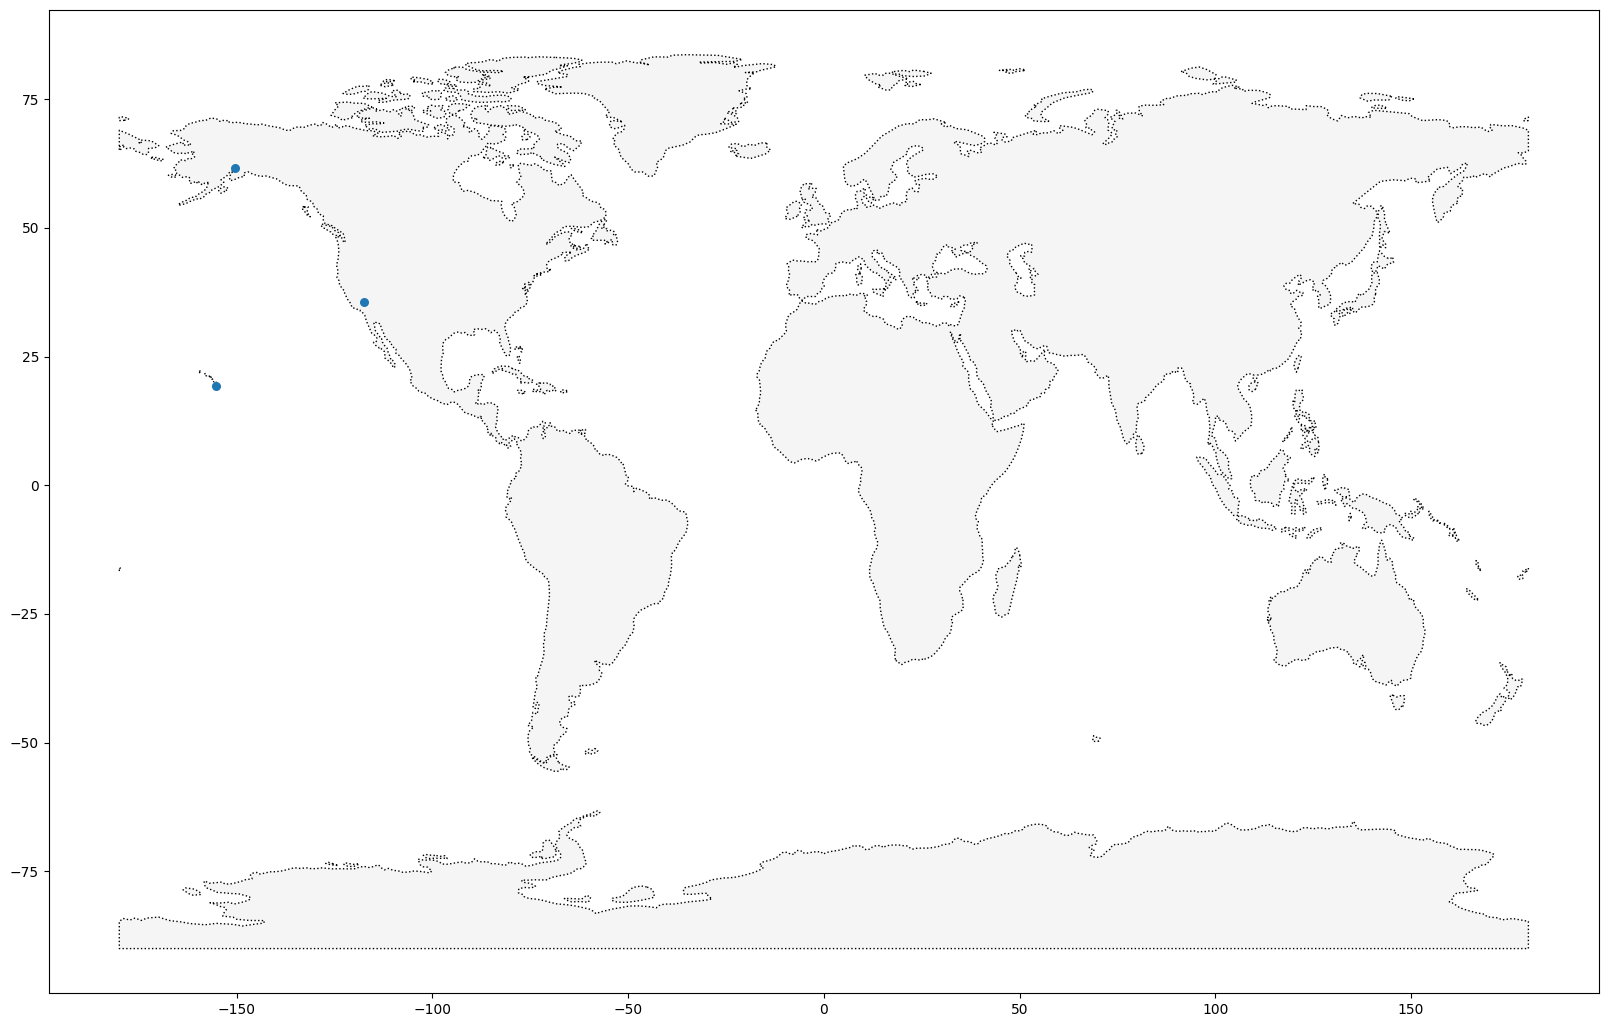

In [12]:
df = pd.DataFrame(output.final_answer["points"])
plot_map(df)